<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/%20DeepLab_TFLite_ADE20k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Loading the model files

In [2]:
#@title Downloading and extracting the model checkpoints
MODEL_URL = 'http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz'  # @param ['http://download.tensorflow.org/models/deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz', 'http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz']
MODEL_FILE = MODEL_URL.split('/')[4]
FOLDER_NAME = 'deeplabv3_xception_ade20k_train'# @param ['deeplabv3_mnv2_ade20k_train_2018_12_03', 'deeplabv3_xception_ade20k_train']

#@markdown **Please make sure to change the `FOLDER_NAME` after you change `MODEL_URL`. We maintain a one-to-one mapping in between them.**
#@markdown - http://download.tensorflow.org/models/deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz: `mobilenetv2_ade20k_train`
#@markdown - http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz: `xception65_ade20k_train`

!wget {MODEL_URL}
!tar -xvf {MODEL_FILE}
!ls -lh {FOLDER_NAME}


--2020-06-04 13:32:24--  http://download.tensorflow.org/models/deeplabv3_xception_ade20k_train_2018_05_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460299576 (439M) [application/x-tar]
Saving to: ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’

deeplabv3_xception_ 100%[===================>] 438.98M  71.3MB/s    in 6.2s    

2020-06-04 13:32:30 (71.3 MB/s) - ‘deeplabv3_xception_ade20k_train_2018_05_29.tar.gz’ saved [460299576/460299576]

deeplabv3_xception_ade20k_train/
deeplabv3_xception_ade20k_train/model.ckpt.index
deeplabv3_xception_ade20k_train/frozen_inference_graph.pb
deeplabv3_xception_ade20k_train/model.ckpt.data-00000-of-00001
total 473M
-rw-r--r-- 1 313785 89939 159M May 29  2018 frozen_inference_graph.pb
-rw-r--r-- 1 313785 89939 315M May 29  2018 model.ckpt

## Creating SavedModel from of the frozen graph

In [3]:
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron.
import os

with tf.gfile.GFile(os.path.join(FOLDER_NAME, 'frozen_inference_graph.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session(graph=tf.Graph()) as sess:
    tf.import_graph_def(graph_def, name="")
    
    g = tf.get_default_graph()

    # need to remove the pre-processing and post-processing subgraph
    # https://github.com/tensorflow/models/blob/462459131a741f87c410b5fa51ec9df2c1b1c3ae/research/deeplab/export_model.py#L77
    input_tensor = g.get_tensor_by_name('sub_7:0')
    output_tensor = g.get_tensor_by_name('ResizeBilinear_3:0') # For the other model it should be ResizeBilinear_2:0.

    tf.saved_model.simple_save(
        sess,
        '/content/deeplab_sm',
        inputs={input_tensor.name: input_tensor},
        outputs={output_tensor.name: output_tensor}
    )

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/deeplab_sm/saved_model.pb


In [4]:
!ls -lh /content/deeplab_sm

total 159M
-rw-r--r-- 1 root root 159M Jun  4 13:32 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jun  4 13:32 variables


## Switch to TensorFlow 2

Restart your runtime.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf 
print(tf.__version__)

2.2.0


## Conversion to TF Lite

In [2]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/deeplab_sm')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
with tf.io.gfile.GFile('deeplab.tflite', 'wb') as f:
    f.write(tflite_model)

!ls -lh deeplab.tflite

-rw-r--r-- 1 root root 40M Jun  4 13:33 deeplab.tflite


## Inference

In [4]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path='deeplab.tflite')

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# get image size - converting from BHWC to WH
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(513, 513)


In [5]:
!wget https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image1.jpg

--2020-06-04 13:33:46--  https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image1.jpg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image1.jpg [following]
--2020-06-04 13:33:46--  https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151959 (148K) [image/jpeg]
Saving to: ‘image1.jpg’

image1.jpg          100%[===================>] 148.40K  --.-KB/s    in 0.02s   

2020-06-04 13:33:47 (5.91 MB/s) - ‘image1.jpg’ saved [151959/15195

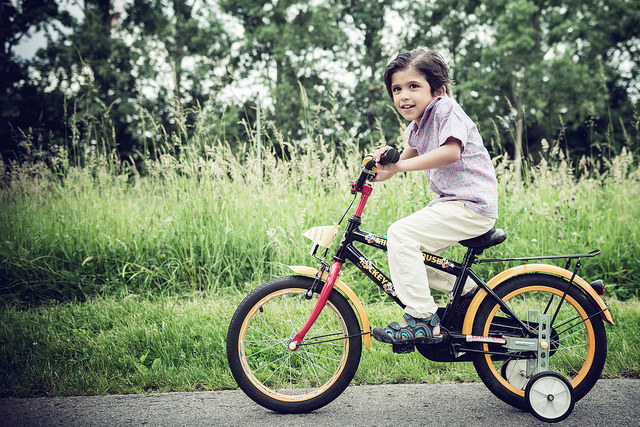

In [6]:
from PIL import Image

image = Image.open('image1.jpg')
image

In [0]:
# Preprocessing: convert the input image to the size required by the model
# Courtesy: Khanh
import numpy as np 

resized_image = image.convert('RGB').resize(input_size, Image.BILINEAR)
# Add a batch dimension and convert to a NumPy array
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 255.0

# Load the model.
interpreter = tf.lite.Interpreter(model_path='deeplab.tflite')

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

In [8]:
!wget https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv
import pandas as pd

ade20k_labels_info = pd.read_csv('objectInfo150.csv')
labels_list = list(ade20k_labels_info['Name'])
len(labels_list)

--2020-06-04 13:34:06--  https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5803 (5.7K) [text/plain]
Saving to: ‘objectInfo150.csv’

objectInfo150.csv   100%[===================>]   5.67K  --.-KB/s    in 0s      

2020-06-04 13:34:06 (52.4 MB/s) - ‘objectInfo150.csv’ saved [5803/5803]



150

In [0]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_ade20k_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray(labels_list)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

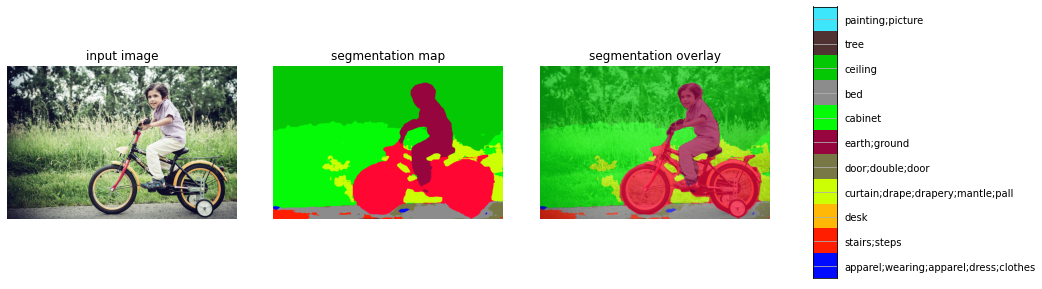

In [10]:
vis_segmentation(image, seg_map)